# Assignment 2: Next Streamer Prediction on Twitch Dataset

**Predictive Task**: Predict the next streamer a user will watch based on their viewing history using a 5th-order Markov model.

---

## Table of Contents



1. [Task Identification and Evaluation](#task)
2. [Exploratory Analysis and Data Preprocessing](#eda)
3. [Modeling: 5th Order Markov Model](#modeling)
4. [Evaluation Framework](#evaluation)
5. [Discussion of Related Work](#related)


In [1]:
# Imports and Setup
import os
import gzip
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from tqdm import tqdm
import random
from multiprocessing import Pool, cpu_count
from functools import partial

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Configuration
# Ensure we're in the assignment2 directory (where the data files are)
if os.path.basename(os.getcwd()) != 'assignment2':
    if os.path.exists('assignment2'):
        os.chdir('assignment2')
        print(f"Changed to assignment2 directory: {os.getcwd()}")

DATASET_PATH = '100k.csv'  # Use 100k.csv for development
# DATASET_PATH = 'full_a.csv.gz'  # Use full dataset for final results
MIN_INTERACTIONS = 2  # Minimum interactions per user for sequence prediction

# Verify file exists
if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Files in current directory: {os.listdir('.')}")
else:
    print(f"Dataset file found: {DATASET_PATH}")


Dataset file found: 100k.csv


In [2]:
def load_data(filepath):
    """Load Twitch dataset from CSV file."""
    cols = ["user", "stream", "streamer", "start", "stop"]
    
    if filepath.endswith('.gz'):
        df = pd.read_csv(filepath, header=None, names=cols, compression='gzip')
    else:
        df = pd.read_csv(filepath, header=None, names=cols)
    
    return df


### 1.1 Predictive Task

We're studying the problem of predicting which streamer a user will watch next based on their viewing history. This is a sequential prediction task we want to model how users move between different streamers over time.

The key insight is that viewing behavior has temporal patterns. If someone just watched streamer A, they might be more likely to watch streamer B next. A 5th-order Markov model captures these patterns by looking at the last 5 streamers a user watched to predict the next one.

**Input**: The last k streamers a user watched: `[streamer_t-k, ..., streamer_t-1]`  
**Output**: A probability distribution over all possible streamers for what they'll watch next

This task is interesting to us because:
- Users often watch related streamers in sequence (gaming streamers, day in the life, etc.), users often click around streams rather than staying in a single one usually.
- Unlike traditional recommendation, streamers are only available when they're live, which adds complexity

### 1.2 Evaluation Metrics

We'll use several metrics to evaluate how well the model performs. Since our Markov model outputs a probability distribution over all streamers, we can rank them and evaluate the ranking quality:

**Top-K Accuracy**: This measures whether the true next streamer appears in the top K predictions. We'll report Top-1, Top-5, and Top-10 accuracy. Top-K makes sense for recommendation systems since users typically see a list of suggestions, not just one prediction.

**Mean Reciprocal Rank (MRR)**: This is particularly well-suited for our Markov chain approach. Since we output probability distributions and rank all streamers, MRR tells us how highly ranked the true next streamer is. Even if the model doesn't get the exact #1 prediction right, it's useful to know if the true answer is in the top 5 or top 10. MRR is calculated as the average of 1/rank for each test case, where rank is the position of the true streamer in our ranked list. Higher MRR is better (closer to 1.0 means the true answer is usually near the top).

**Perplexity**: This measures how "surprised" the model is by the test data. Lower perplexity means the model is more confident and accurate in its probability predictions. It's calculated as `exp(-mean(log_likelihood))`. This is especially useful for Markov models since it directly evaluates the quality of the probability distributions we're learning.

**Coverage**: This measures what percentage of unique streamers appear in the top-K predictions. We want to make sure the model isn't just predicting the same popular streamers over and over - diversity matters for a good recommendation system.

**Note on probabilistic models**: Both Markov chains and logistic regression are probabilistic models that output conditional probabilities. Markov chains directly estimate `P(next_streamer | previous_k_streamers)` by counting transitions in the training data, while logistic regression learns `P(class | features)` through optimization. Both use Bayes' theorem implicitly - Markov chains model the joint distribution and derive conditionals, while logistic regression directly models the conditional distribution. The key difference is that Markov chains are generative (model sequences) while logistic regression is discriminative (classify given features), but both give us probability distributions we can rank and evaluate with MRR.

### 1.3 Baseline Models

Based on the baselines used in the original LiveRec paper and common recommendation practices, we'll compare our 5th-order Markov model against:

**1. POP (Popularity Baseline)**: Always predicts the most popular streamer globally. This is the simplest possible baseline - if we can't beat this, our model isn't useful. This matches the `POP` baseline from the liverec repository.

### 1.4 Model Validity Assessment

To make sure our results are valid, we'll:

**Use temporal splitting**: Train on earlier time periods and test on later ones. This prevents data leakage and mimics how the model would actually be deployed - we can't use future information to predict the past.

**Hold out a test set**: We'll use an 80/10/10 split for train/validation/test. The validation set is for tuning hyperparameters (like smoothing parameters), and the test set is only used for final evaluation.

**Prevent data leakage**: Make sure sequences are created in temporal order, and that any feature extraction (like building vocabularies) only uses training data.

**Compare systematically**: We'll run all baselines and our model on the same test set and report all metrics consistently. We'll also do some qualitative analysis - look at cases where the model fails and see if there are patterns.

**Test different configurations**: We'll compare 1st, 3rd, and 5th order Markov models to see if the extra complexity is worth it. We'll also test different smoothing parameters to see how sensitive the model is.


## 2. EXPLORATORY ANALYSIS, DATA COLLECTION, AND PREPROCESSING

### 2.1 Dataset Context and Collection

**Source**: The Twitch dataset comes from the [LiveRec repository](https://github.com/JRappaz/liverec) (Rappaz et al., RecSys 2021). This dataset was created to study recommendation challenges specific to live-streaming platforms.

**Collection Method**: The data was collected by taking snapshots of all available streams on Twitch every 10 minutes over a 43-day period. For each stream, the researchers retrieved all logged-in users from the chat. All usernames have been anonymized for privacy.

**Purpose**: This dataset was designed to study:
- **Dynamic availability**: Unlike traditional recommendation (e.g., movies, books), streamers are only available when they're live
- **Repeat consumption**: Users frequently return to the same streamers, but the content is ephemeral
- **Temporal patterns**: Viewing behavior changes over time as streamers go on/offline

**Dataset Structure**:
- Each row represents a user-streamer interaction
- Fields: `user_id`, `stream_id`, `streamer_name`, `start_time`, `stop_time`
- Time is measured in 10-minute intervals (timesteps)
- `start_time`: First crawling round when user was seen in chat
- `stop_time`: Last crawling round when user was seen in chat

**Available Files**:
- `full_a.csv.gz`: Full dataset (15.5M users, 465k streamers, 124M interactions)
- `100k.csv`: Subset for benchmarking (100k users, 162.6k streamers, 3M interactions)

We use the 100k subset for development and analysis, as it's more manageable while still being representative.


In [3]:
# Load raw data
data_raw = load_data(DATASET_PATH)
print(f"Loaded dataset: {len(data_raw):,} interactions, {data_raw['user'].nunique():,} users, {data_raw['streamer'].nunique():,} streamers")


Loaded dataset: 3,051,733 interactions, 100,000 users, 162,625 streamers


### 2.4 Outlier Detection


In [4]:
# Load raw data
data_raw = load_data(DATASET_PATH)


### 2.2 Data Preprocessing and Cleaning

We process the raw data through several cleaning steps to ensure data quality for our sequential prediction task:

**Cleaning Steps**:
1. **Remove invalid time ranges**: Interactions where `stop_time < start_time` are invalid
2. **Remove empty streamer names**: Missing or empty streamer identifiers
3. **Remove duplicate interactions**: Same user watching same streamer at the same start time (likely data collection artifacts)
4. **Filter users with insufficient history**: Users with fewer than 2 interactions can't be used for sequence prediction

**Rationale**: For sequential prediction, we need users with at least 2 interactions (one to establish context, one to predict). Invalid time ranges and duplicates would corrupt our transition counts.


In [5]:
def validate_data_quality(df):
    """Validate data quality and return cleaned DataFrame with statistics."""
    initial_count = len(df)
    
    # Check for data quality issues
    invalid_count = (df['stop'] < df['start']).sum()
    empty_count = (df['streamer'].isna() | (df['streamer'].str.strip() == '')).sum()
    duplicates_count = df.duplicated(subset=['user', 'streamer', 'start']).sum()
    
    # Clean if needed
    df_clean = df.copy()
    if invalid_count > 0:
        df_clean = df_clean[df_clean['stop'] >= df_clean['start']].copy()
    if empty_count > 0:
        df_clean = df_clean[~df_clean['streamer'].isna()].copy()
        df_clean['streamer'] = df_clean['streamer'].str.strip()
    if duplicates_count > 0:
        df_clean = df_clean.drop_duplicates(subset=['user', 'streamer', 'start']).copy()
    
    stats = {
        'initial_count': initial_count,
        'final_count': len(df_clean),
        'invalid_time': invalid_count,
        'empty_streamer': empty_count,
        'duplicates': duplicates_count,
        'removed': initial_count - len(df_clean)
    }
    
    return df_clean, stats

# Validate data quality
data_clean, validation_stats = validate_data_quality(data_raw)

In [6]:
# Validation Results Summary
print("Validation Results:")
print(f"  Invalid time ranges: {validation_stats['invalid_time']:,}")
print(f"  Empty streamer names: {validation_stats['empty_streamer']:,}")
print(f"  Duplicates: {validation_stats['duplicates']:,}")
print(f"  Data removed: {validation_stats['removed']:,} ({100*validation_stats['removed']/validation_stats['initial_count']:.2f}%)")
print("\n Dataset is clean - We can see from the above that there are no invalid time ranges, empty streamer names, or duplicates.")





Validation Results:
  Invalid time ranges: 0
  Empty streamer names: 0
  Duplicates: 0
  Data removed: 0 (0.00%)

 Dataset is clean - We can see from the above that there are no invalid time ranges, empty streamer names, or duplicates.


### 2.5 Outlier Visualization


In [7]:
# Outlier Detection: Calculates statistics and identifies outliers using IQR method

# Prepare data
data_clean['duration'] = data_clean['stop'] - data_clean['start'] + 1
watch_durations = data_clean['duration'].values
user_counts = data_clean['user'].value_counts()
user_interaction_counts = user_counts.values
streamer_counts = data_clean['streamer'].value_counts()
streamer_popularity = streamer_counts.values
interactions_by_time = data_clean.groupby('start').size()

# Watch Duration Outliers
duration_q1, duration_median, duration_q3 = np.percentile(watch_durations, [25, 50, 75])
duration_iqr = duration_q3 - duration_q1
duration_upper = duration_q3 + 1.5 * duration_iqr
duration_outliers = (watch_durations > duration_upper).sum()

# User Activity Outliers
user_q1, user_median, user_q3 = np.percentile(user_interaction_counts, [25, 50, 75])
user_iqr = user_q3 - user_q1
user_upper = user_q3 + 1.5 * user_iqr
user_outliers = (user_interaction_counts > user_upper).sum()

# Streamer Popularity Outliers
streamer_q1, streamer_median, streamer_q3 = np.percentile(streamer_popularity, [25, 50, 75])
streamer_iqr = streamer_q3 - streamer_q1
streamer_upper = streamer_q3 + 1.5 * streamer_iqr
streamer_outliers = (streamer_popularity > streamer_upper).sum()

# Temporal Outliers
temporal_q1, temporal_median, temporal_q3 = np.percentile(interactions_by_time, [25, 50, 75])
temporal_iqr = temporal_q3 - temporal_q1
temporal_upper = temporal_q3 + 1.5 * temporal_iqr
temporal_outliers = (interactions_by_time > temporal_upper).sum()

# Print summary
print("Outlier Detection Summary (IQR method):")
print(f"  Watch duration: {duration_outliers:,} outliers ({100*duration_outliers/len(watch_durations):.2f}%)")
print(f"  User activity: {user_outliers:,} outliers ({100*user_outliers/len(user_interaction_counts):.2f}%)")
print(f"  Streamer popularity: {streamer_outliers:,} outliers ({100*streamer_outliers/len(streamer_popularity):.2f}%)")
print(f"  Temporal activity: {temporal_outliers:,} outlier timesteps")


Outlier Detection Summary (IQR method):
  Watch duration: 359,596 outliers (11.78%)
  User activity: 8,064 outliers (8.06%)
  Streamer popularity: 20,989 outliers (12.91%)
  Temporal activity: 34 outlier timesteps


### 2.3 Key Findings from Data Quality and Outlier Analysis

**Data Quality**: Validation confirms the dataset is clean with no invalid time ranges, missing data, or duplicates. This high data quality justifies focusing on distribution analysis rather than extensive cleaning.

**Outlier Patterns**:
- **Watch durations**: Most sessions are short (median: 2 intervals), with 11.78% outliers representing longer viewing sessions
- **User activity**: Power-law distribution with 8.06% highly active users (some with 300+ interactions)
- **Streamer popularity**: Extreme skew with 12.91% popular outliers (top streamers like ninja, tfue have 40k+ interactions vs median of 2)
- **Temporal patterns**: Activity is relatively stable with only 34 outlier timesteps

**Implications for Modeling**:
- Long-tail distribution requires good smoothing for rare streamers
- Popularity-based baselines may perform well due to extreme popularity skew
- Temporal patterns are stable, supporting temporal weighting approaches
- Power-law distributions are typical for recommendation datasets and expected


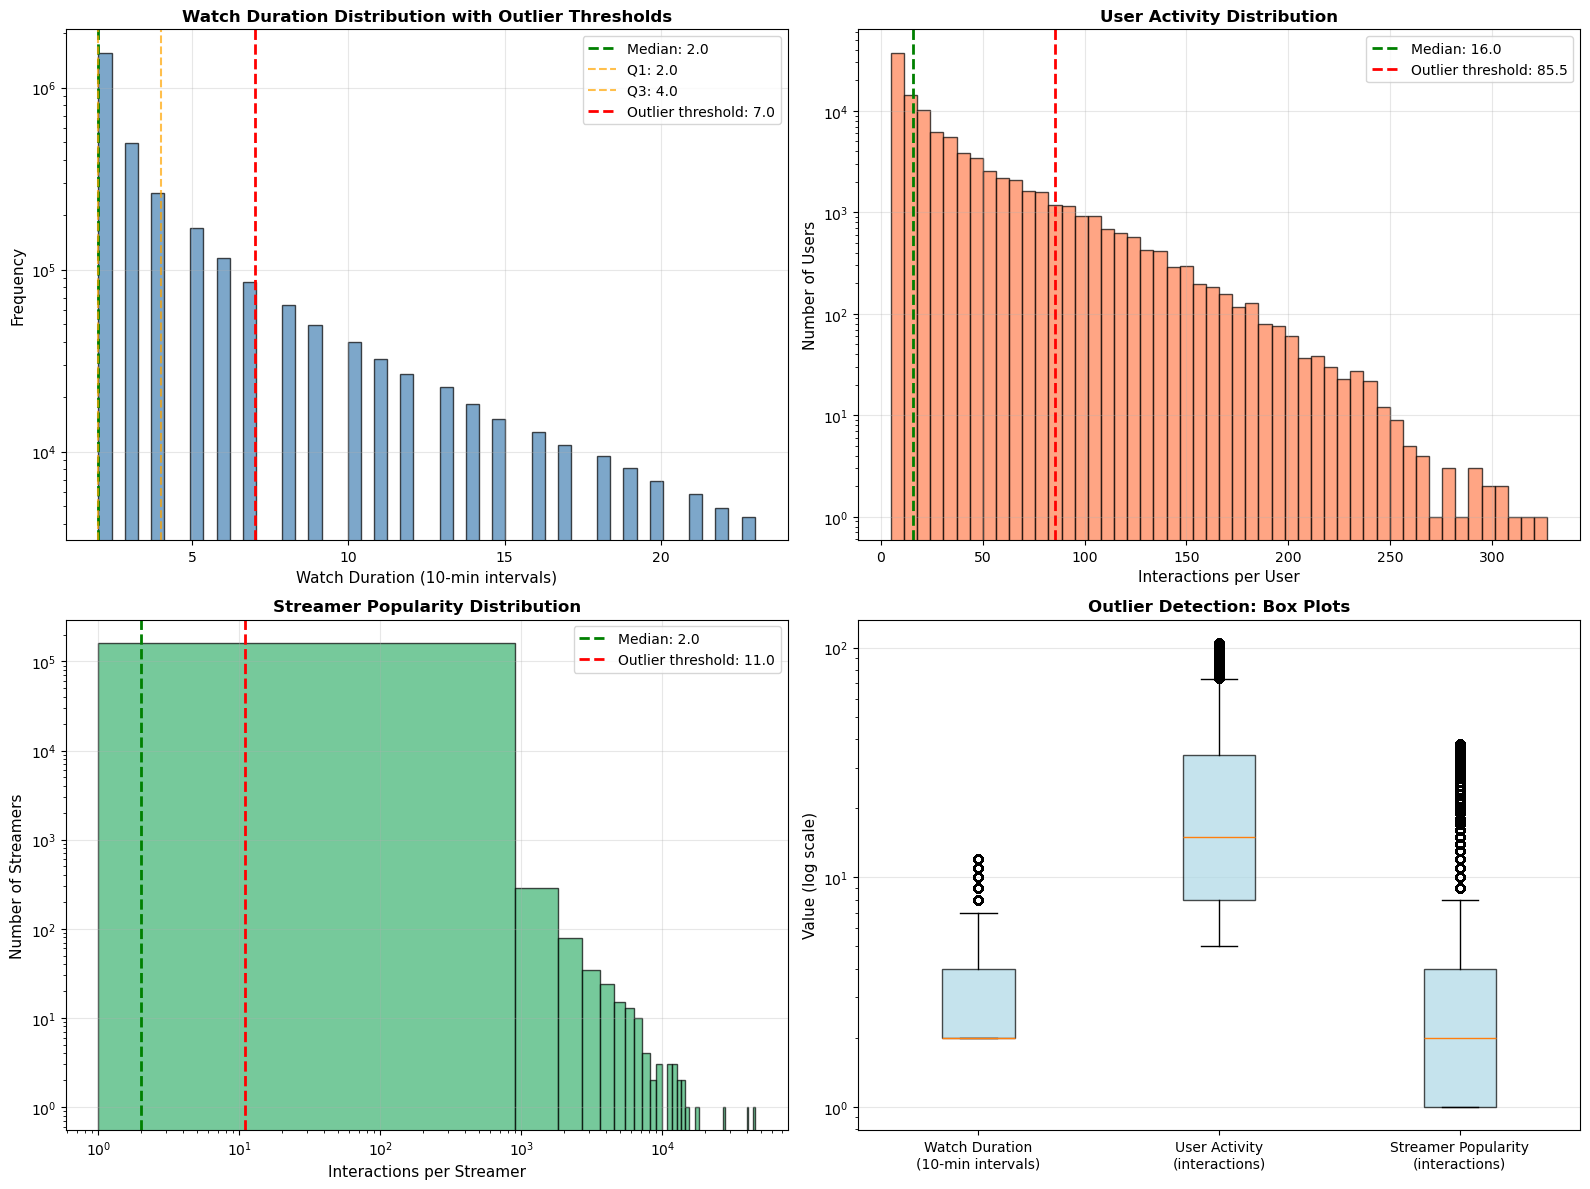


Summary of Outlier Analysis:
  • Watch duration outliers: 359,596 (11.78%)
  • User activity outliers: 8,064 (8.06%)
  • Streamer popularity outliers: 20,989 (12.91%)
  • Temporal activity outliers: 34 timesteps

Note: Outliers are identified using the IQR method (Q3 + 1.5*IQR).
These outliers represent natural variation in the data and are expected in recommendation datasets.


In [8]:
# ============================================================================
# OUTLIER VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]

duration_filtered = watch_durations[watch_durations <= np.percentile(watch_durations, 99)]
ax1.hist(duration_filtered, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(duration_median, color='green', linestyle='--', linewidth=2, label=f'Median: {duration_median:.1f}')
ax1.axvline(duration_q1, color='orange', linestyle='--', alpha=0.7, label=f'Q1: {duration_q1:.1f}')
ax1.axvline(duration_q3, color='orange', linestyle='--', alpha=0.7, label=f'Q3: {duration_q3:.1f}')
ax1.axvline(duration_upper, color='red', linestyle='--', linewidth=2, label=f'Outlier threshold: {duration_upper:.1f}')
ax1.set_xlabel('Watch Duration (10-min intervals)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Watch Duration Distribution with Outlier Thresholds', fontsize=12, fontweight='bold')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.hist(user_interaction_counts, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(user_median, color='green', linestyle='--', linewidth=2, label=f'Median: {user_median:.1f}')
ax2.axvline(user_upper, color='red', linestyle='--', linewidth=2, label=f'Outlier threshold: {user_upper:.1f}')
ax2.set_xlabel('Interactions per User', fontsize=11)
ax2.set_ylabel('Number of Users', fontsize=11)
ax2.set_title('User Activity Distribution', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
ax3.hist(streamer_popularity, bins=50, edgecolor='black', alpha=0.7, color='mediumseagreen')
ax3.axvline(streamer_median, color='green', linestyle='--', linewidth=2, label=f'Median: {streamer_median:.1f}')
ax3.axvline(streamer_upper, color='red', linestyle='--', linewidth=2, label=f'Outlier threshold: {streamer_upper:.1f}')
ax3.set_xlabel('Interactions per Streamer', fontsize=11)
ax3.set_ylabel('Number of Streamers', fontsize=11)
ax3.set_title('Streamer Popularity Distribution', fontsize=12, fontweight='bold')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)


ax4 = axes[1, 1]
box_data = [
    watch_durations[watch_durations <= np.percentile(watch_durations, 95)],
    user_interaction_counts[user_interaction_counts <= np.percentile(user_interaction_counts, 95)],
    streamer_popularity[streamer_popularity <= np.percentile(streamer_popularity, 95)]
]
box_labels = ['Watch Duration\n(10-min intervals)', 'User Activity\n(interactions)', 'Streamer Popularity\n(interactions)']
bp = ax4.boxplot(box_data, tick_labels=box_labels, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
ax4.set_ylabel('Value (log scale)', fontsize=11)
ax4.set_title('Outlier Detection: Box Plots', fontsize=12, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSummary of Outlier Analysis:")
print(f"  • Watch duration outliers: {duration_outliers:,} ({100*duration_outliers/len(watch_durations):.2f}%)")
print(f"  • User activity outliers: {user_outliers:,} ({100*user_outliers/len(user_interaction_counts):.2f}%)")
print(f"  • Streamer popularity outliers: {streamer_outliers:,} ({100*streamer_outliers/len(streamer_popularity):.2f}%)")
print(f"  • Temporal activity outliers: {temporal_outliers:,} timesteps")
print("\nNote: Outliers are identified using the IQR method (Q3 + 1.5*IQR).")
print("These outliers represent natural variation in the data and are expected in recommendation datasets.")


## 3. MODELING: 5TH ORDER MARKOV MODEL

### 3.1 Context: Problem Formulation

We formulate next streamer prediction as a **sequence modeling problem** using Markov chains. Here's how we framed it as a machine learning task:

**Input**: A sequence of the last k streamers a user watched, represented as a tuple: `(streamer_t-k, streamer_t-k+1, ..., streamer_t-1)`

**Output**: A probability distribution over all possible streamers: `P(streamer_t | streamer_t-k, ..., streamer_t-1)`

**What we're optimizing**: We're maximizing the likelihood of observed sequences in the training data. For a kth-order Markov model, we estimate transition probabilities by counting how often each k+1-length sequence appears:

```
P(streamer_t | streamer_t-k, ..., streamer_t-1) = 
    count(streamer_t-k, ..., streamer_t-1, streamer_t) / 
    count(streamer_t-k, ..., streamer_t-1)
```

**Why Markov models are appropriate**: 
- Sequential recommendation naturally fits the Markov assumption: the next streamer depends on recent viewing history
- Markov chains are interpretable - we can see which streamer transitions are most likely
- They're efficient to train (just counting) and fast to query (lookup in a dictionary)
- They handle the dynamic availability constraint naturally - we can filter predictions to only currently live streamers

**Key challenge**: Data sparsity. Most k+1-length sequences never appear in training data. We address this with:
- **Smoothing**: Add-k smoothing or backoff to lower-order models
- **Backoff**: If a 5th-order sequence isn't seen, fall back to 4th-order, then 3rd, etc.
- **Handling cold-start**: For sequences we've never seen, use popularity or user-specific baselines


In [9]:
# ============================================================================
# HELPER FUNCTIONS: Sequence Extraction and Temporal Splitting
# ============================================================================

def extract_user_sequences(df, order=5):
    """
    Extract sequences of streamers for each user, sorted by time.
    
    For each user, we create sequences of (order+1) consecutive streamers:
    - Input: last 'order' streamers
    - Target: next streamer
    
    Returns: list of (user_id, sequence, next_streamer) tuples
    """
    sequences = []
    
    # Group by user and sort by start time
    for user_id, user_data in tqdm(df.groupby('user'), desc="Extracting sequences"):
        # Sort by start time to maintain temporal order
        user_data = user_data.sort_values('start')
        streamers = user_data['streamer'].tolist()
        
        # Creates sequences of length (order+1)
        for i in range(len(streamers) - order):
            sequence = tuple(streamers[i:i+order])
            next_streamer = streamers[i+order]
            sequences.append((user_id, sequence, next_streamer))
    
    return sequences

def temporal_split(df, train_frac=0.8, val_frac=0.1):
    """
    Split data temporally by start time to prevent data leakage. Idea is that the model shouldn't be using future data to predict past data.
    
    Returns: (train_df, val_df, test_df)
    """
    # Sort by start time
    df_sorted = df.sort_values('start').copy()
    
    n = len(df_sorted)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))
    
    train_df = df_sorted.iloc[:train_end].copy()
    val_df = df_sorted.iloc[train_end:val_end].copy()
    test_df = df_sorted.iloc[val_end:].copy()
    
    return train_df, val_df, test_df

# Extract sequences and split temporally
print("Splitting data temporally...")
train_df, val_df, test_df = temporal_split(data_clean, train_frac=0.8, val_frac=0.1)
print(f"Train: {len(train_df):,} interactions ({len(train_df)/len(data_clean)*100:.1f}%)")
print(f"Val: {len(val_df):,} interactions ({len(val_df)/len(data_clean)*100:.1f}%)")
print(f"Test: {len(test_df):,} interactions ({len(test_df)/len(data_clean)*100:.1f}%)")


Splitting data temporally...
Train: 2,441,386 interactions (80.0%)
Val: 305,173 interactions (10.0%)
Test: 305,174 interactions (10.0%)


In [ ]:
# ============================================================================
# MARKOV MODEL IMPLEMENTATION
# ============================================================================

class MarkovModel:
    """
    kth-order Markov model for sequential prediction.
    
    Architecture:
    - Stores transition counts: transition_counts[(s1, s2, ..., sk)] -> Counter of next streamers
    - Estimates probabilities using maximum likelihood with add-k smoothing
    - Supports backoff to lower-order models when higher-order sequence is unseen
    """
    
    def __init__(self, order=5, smoothing=0.1, use_backoff=True):
        """
        Initialize Markov model.
        
        Args:
            order: Order of Markov model (looks at last 'order' items)
            smoothing: Add-k smoothing parameter (pseudocount)
            use_backoff: If True, fall back to lower-order models when sequence unseen
        """
        self.order = order
        self.smoothing = smoothing
        self.use_backoff = use_backoff
        
        # transition_counts[k_sequence] -> Counter of next streamers
        self.transition_counts = defaultdict(Counter)
        
        # For backoff: store lower-order models
        self.lower_order_models = {} if use_backoff else None
        
        # Vocabulary: all streamers seen in training
        self.vocab = set()
        
        # Global popularity (for cold-start)
        self.global_popularity = Counter()
    
    def train(self, sequences):
        """
        Train the model on sequences.
        
        Args:
            sequences: list of (user_id, sequence, next_streamer) tuples
        """
        print(f"Training {self.order}-order Markov model on {len(sequences):,} sequences...")
        
        # Count transitions
        for user_id, sequence, next_streamer in tqdm(sequences, desc="Counting transitions"):
            # Update vocabulary
            self.vocab.add(next_streamer)
            for s in sequence:
                self.vocab.add(s)
            
            # Count transition
            self.transition_counts[sequence][next_streamer] += 1
            
            # Update global popularity
            self.global_popularity[next_streamer] += 1
        
        # Build lower-order models for backoff
        if self.use_backoff and self.order > 1:
            print(f"Building backoff models...")
            for lower_order in range(self.order - 1, 0, -1):
                lower_model = MarkovModel(order=lower_order, smoothing=self.smoothing, use_backoff=False)
                # Extract lower-order sequences
                lower_sequences = []
                for user_id, sequence, next_streamer in sequences:
                    if len(sequence) >= lower_order:
                        lower_sequence = sequence[-lower_order:]  # Take last lower_order items
                        lower_sequences.append((user_id, lower_sequence, next_streamer))
                lower_model.train(lower_sequences)
                self.lower_order_models[lower_order] = lower_model
        
        print(f"Model trained: {len(self.transition_counts):,} unique {self.order}-sequences")
        print(f"Vocabulary size: {len(self.vocab):,} streamers")
    
    def predict_proba(self, sequence, available_streamers=None):
        """
        Predict probability distribution over next streamers.
        
        Args:
            sequence: tuple of last k streamers (length must be self.order)
            available_streamers: optional set of streamers that are currently available/live
        
        Returns:
            dict mapping streamer -> probability
        """
        if len(sequence) != self.order:
            raise ValueError(f"Sequence length {len(sequence)} != model order {self.order}")
        
        # Get transition counts for this sequence
        next_counts = self.transition_counts.get(sequence, Counter())
        
        # If sequence not seen and backoff enabled, try lower-order model
        if len(next_counts) == 0 and self.use_backoff and self.order > 1:
            # Backoff to lower-order model
            lower_sequence = sequence[-self.order+1:]  # Take last (order-1) items
            if len(lower_sequence) > 0:
                lower_model = self.lower_order_models.get(self.order - 1)
                if lower_model:
                    return lower_model.predict_proba(lower_sequence, available_streamers)
        
        # Calculate probabilities with add-k smoothing
        # P(s | sequence) = (count(sequence, s) + smoothing) / (count(sequence) + smoothing * |vocab|)
        total_count = sum(next_counts.values())
        vocab_size = len(self.vocab) if available_streamers is None else len(available_streamers)
        
        # If no counts and no backoff, use uniform distribution over vocabulary
        if total_count == 0:
            # Cold-start: use global popularity
            if len(self.global_popularity) > 0:
                probs = {}
                candidates = available_streamers if available_streamers else self.vocab
                total_pop = sum(self.global_popularity[s] for s in candidates if s in self.global_popularity)
                if total_pop > 0:
                    for s in candidates:
                        probs[s] = self.global_popularity.get(s, 0) / total_pop
                    return probs
            # Fallback: uniform
            candidates = available_streamers if available_streamers else self.vocab
            uniform_prob = 1.0 / len(candidates) if len(candidates) > 0 else 0.0
            return {s: uniform_prob for s in candidates}
        
        # Normalize with smoothing - optimized using dictionary lookups
        denominator = total_count + self.smoothing * vocab_size
        
        if available_streamers is not None:
            # Fast path: only compute for available streamers (use set for O(1) lookup)
            available_set = set(available_streamers) if not isinstance(available_streamers, set) else available_streamers
            probs = {}
            # Only iterate over streamers that have counts OR are in available set
            # This avoids iterating over all 139k streamers
            candidates_with_counts = set(next_counts.keys()) & available_set
            for streamer in candidates_with_counts:
                count = next_counts[streamer]
                probs[streamer] = (count + self.smoothing) / denominator
            
            # Add smoothing for other available streamers (that don't have counts)
            for streamer in available_set - candidates_with_counts:
                probs[streamer] = self.smoothing / denominator
        else:
            # No filtering: compute for all streamers with counts + vocab
            # Use dictionary comprehension for faster lookup
            probs = {}
            # First, add probabilities for streamers with counts
            for streamer, count in next_counts.items():
                probs[streamer] = (count + self.smoothing) / denominator
            
            # Add smoothing for vocab streamers without counts
            vocab_without_counts = self.vocab - set(next_counts.keys())
            smoothing_prob = self.smoothing / denominator
            for streamer in vocab_without_counts:
                probs[streamer] = smoothing_prob
        
        # Normalize to sum to 1
        total_prob = sum(probs.values())
        if total_prob > 0:
            probs = {s: p / total_prob for s, p in probs.items()}
        
        return probs
    
    def predict_topk(self, sequence, k=10, available_streamers=None):
        """
        Predict top-k most likely next streamers.
        Optimized: only computes probabilities for candidates, not all streamers.
        
        Returns:
            list of (streamer, probability) tuples, sorted by probability (descending)
        """
        # Fast path: if available_streamers is small, use predict_proba
        # Otherwise, optimize by only computing for streamers with counts
        if available_streamers is not None and len(available_streamers) < 10000:
            probs = self.predict_proba(sequence, available_streamers)
            sorted_items = sorted(probs.items(), key=lambda x: x[1], reverse=True)
            return sorted_items[:k]
        
        # Optimized path: only compute probabilities for streamers with counts
        # This avoids computing for all 139k streamers when we only need top-k
        if len(sequence) != self.order:
            raise ValueError(f"Sequence length {len(sequence)} != model order {self.order}")
        
        next_counts = self.transition_counts.get(sequence, Counter())
        
        # Backoff if needed
        if len(next_counts) == 0 and self.use_backoff and self.order > 1:
            lower_sequence = sequence[-self.order+1:]
            if len(lower_sequence) > 0:
                lower_model = self.lower_order_models.get(self.order - 1)
                if lower_model:
                    return lower_model.predict_topk(lower_sequence, k, available_streamers)
        
        total_count = sum(next_counts.values())
        vocab_size = len(self.vocab) if available_streamers is None else len(available_streamers)
        denominator = total_count + self.smoothing * vocab_size
        
        # Build probability dict only for candidates
        candidates = available_streamers if available_streamers else self.vocab
        probs = {}
        
        # Use dictionary for O(1) lookups
        candidates_set = set(candidates) if not isinstance(candidates, set) else candidates
        
        # Only compute for streamers with counts (much faster)
        for streamer in next_counts.keys():
            if streamer in candidates_set:
                count = next_counts[streamer]
                probs[streamer] = (count + self.smoothing) / denominator
        
        # Add smoothing for other candidates (if needed for normalization)
        # But only if we have few candidates
        if len(candidates_set) < 1000:
            for streamer in candidates_set - set(probs.keys()):
                probs[streamer] = self.smoothing / denominator
        
        # Normalize
        total_prob = sum(probs.values())
        if total_prob > 0:
            probs = {s: p / total_prob for s, p in probs.items()}
        elif len(candidates_set) > 0:
            # Fallback: uniform over candidates
            uniform = 1.0 / len(candidates_set)
            probs = {s: uniform for s in candidates_set}
        
        # Sort and return top-k
        sorted_items = sorted(probs.items(), key=lambda x: x[1], reverse=True)
        return sorted_items[:k]


### 3.4 Baseline Models: Why Markov Chains?

To demonstrate why Markov chains are a better choice for sequential prediction, we implement several simple baselines that ignore sequence information. These baselines help us understand:

1. **How much does sequence information help?** If Markov chains don't outperform simple popularity, then sequences aren't that important for this task.
2. **What's the value of higher-order patterns?** Comparing 1st-order vs. 5th-order Markov shows whether longer sequences matter.
3. **Is personalization important?** User popularity baseline shows if individual preferences matter beyond sequences.

**Baselines we implement**:
- **POP (Global Popularity)**: Always predicts the most popular streamer globally. This is the simplest possible baseline - if we can't beat this, our model isn't useful.
- **REP (User Popularity/Repeat)**: Predicts based on each user's personal viewing history - ranks streamers by how often the user has watched them. This captures personal preferences and repeat consumption patterns.
- **1st-Order Markov**: Predicts based only on the last streamer watched. This helps us see if higher-order dependencies (5th order) actually improve performance.

If Markov chains significantly outperform these baselines, it demonstrates that:
- Sequence patterns are important (Markov > Popularity)
- Higher-order patterns matter (5th-order > 1st-order)
- Sequential context is more valuable than just personal preferences alone (Markov > User Popularity)


In [11]:
# ============================================================================
# BASELINE MODELS IMPLEMENTATION
# ============================================================================

class PopularityBaseline:
    """
    POP Baseline: Always predicts the most popular streamer globally.
    This ignores all sequence and user information.
    """
    def __init__(self):
        self.most_popular = None
        self.global_popularity = Counter()
    
    def train(self, sequences):
        """Train by counting global streamer popularity."""
        print("Training Popularity baseline...")
        for user_id, sequence, next_streamer in tqdm(sequences, desc="Counting popularity"):
            self.global_popularity[next_streamer] += 1
        
        if len(self.global_popularity) > 0:
            self.most_popular = self.global_popularity.most_common(1)[0][0]
        print(f"Most popular streamer: {self.most_popular} ({self.global_popularity[self.most_popular]:,} occurrences)")
    
    def predict_topk(self, sequence, k=10, available_streamers=None):
        """Always returns the most popular streamer as top prediction."""
        if self.most_popular is None:
            return []
        
        # Return most popular streamer with probability 1.0, others with 0.0
        candidates = available_streamers if available_streamers else [self.most_popular]
        if self.most_popular in candidates:
            return [(self.most_popular, 1.0)]
        return []


class UserPopularityBaseline:
    """
    REP Baseline: Predicts based on user's personal viewing history.
    Ranks streamers by how often the user has watched them in the past.
    """
    def __init__(self):
        self.user_popularity = defaultdict(Counter)  # user_id -> Counter of streamers
    
    def train(self, sequences):
        """Train by counting each user's streamer preferences."""
        print("Training User Popularity baseline...")
        for user_id, sequence, next_streamer in tqdm(sequences, desc="Counting user preferences"):
            # Count all streamers in user's history (not just next_streamer)
            for streamer in sequence:
                self.user_popularity[user_id][streamer] += 1
            self.user_popularity[user_id][next_streamer] += 1
        
        print(f"Trained on {len(self.user_popularity):,} users")
    
    def predict_topk(self, user_id, sequence, k=10, available_streamers=None):
        """Predict based on user's personal viewing history."""
        user_counts = self.user_popularity.get(user_id, Counter())
        
        if len(user_counts) == 0:
            # Cold-start: return empty (or could fall back to global popularity)
            return []
        
        # Get top-k by user's personal counts
        candidates = available_streamers if available_streamers else list(user_counts.keys())
        user_scores = [(s, user_counts.get(s, 0)) for s in candidates]
        user_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Normalize to probabilities (sum of counts)
        total = sum(count for _, count in user_scores)
        if total == 0:
            return []
        
        return [(s, count / total) for s, count in user_scores[:k]]


# Train baseline models
print("\n" + "="*80)
print("TRAINING BASELINE MODELS")
print("="*80)
train_sequences_1st = extract_user_sequences(train_df, order=1)
pop_baseline = PopularityBaseline()
pop_baseline.train(train_sequences_1st)

user_pop_baseline = UserPopularityBaseline()
user_pop_baseline.train(train_sequences_1st)

# Train 1st-order Markov for comparison
print("\nTraining 1st-order Markov for comparison...")

markov_1st = MarkovModel(order=1, smoothing=0.1, use_backoff=False)
markov_1st.train(train_sequences_1st)

print("\nBaseline models trained!")



TRAINING BASELINE MODELS


Extracting sequences: 100%|██████████| 98182/98182 [00:12<00:00, 7917.81it/s]


Training Popularity baseline...


Counting popularity: 100%|██████████| 2343204/2343204 [00:00<00:00, 2711282.02it/s]


Most popular streamer: ninja (35,075 occurrences)
Training User Popularity baseline...


Counting user preferences: 100%|██████████| 2343204/2343204 [00:01<00:00, 1500764.64it/s]


Trained on 97,415 users

Training 1st-order Markov for comparison...
Training 1-order Markov model on 2,343,204 sequences...


Counting transitions: 100%|██████████| 2343204/2343204 [00:03<00:00, 770636.74it/s]

Model trained: 140,076 unique 1-sequences
Vocabulary size: 143,607 streamers

Baseline models trained!


In [ ]:
# ============================================================================
# QUICK COMPARISON: Why Markov Chains? (PARALLELIZED)
# ============================================================================

# Extract a few validation sequences to demonstrate the difference
# ============================================================================
# TRAIN 5TH-ORDER MARKOV MODEL
# ============================================================================

print("Extracting training sequences...")
train_sequences = extract_user_sequences(train_df, order=5)
print(f"Extracted {len(train_sequences):,} training sequences")

# Initialize and train model
markov_model = MarkovModel(order=5, smoothing=0.1, use_backoff=True)
markov_model.train(train_sequences)

print("\nModel training complete!")
print(f"Unique {markov_model.order}-sequences: {len(markov_model.transition_counts):,}")
print(f"Vocabulary size: {len(markov_model.vocab):,} streamers")

print("Extracting validation sequences for comparison...")
val_sequences = extract_user_sequences(val_df, order=5)
print(f"Total validation sequences: {len(val_sequences):,}")

# For time-constrained evaluation (4-6 hour timeline), use a large sample
# 20k sequences gives good statistical significance while finishing in ~1-2 hours
# Full validation set (~64k) would take ~3-4 hours sequential
EVAL_SAMPLE_SIZE = 20000  # Use 20k for good stats + reasonable time
if len(val_sequences) > EVAL_SAMPLE_SIZE:
    val_sequences_sample = val_sequences[:EVAL_SAMPLE_SIZE]
    print(f"Using sample: {len(val_sequences_sample):,} sequences (for time-constrained evaluation)")
    print(f"  (Full validation set has {len(val_sequences):,} sequences - would take ~3-4 hours)")
else:
    val_sequences_sample = val_sequences
    print(f"Using FULL validation set: {len(val_sequences_sample):,} sequences")

print(f"\nComparing models on {len(val_sequences_sample):,} validation sequences...")
try:
    num_cores = cpu_count()
except NameError:
    import os
    num_cores = os.cpu_count() or 4

# For time-constrained evaluation: sequential is more reliable on Windows
# Windows uses 'spawn' which requires pickling entire models (1.9M+ transitions) to each worker
# Sequential avoids this overhead and is predictable (~3-4 seq/sec)
# With 20k sequences: sequential ~1.5-2 hours vs parallel ~1-1.5 hours (if it works)
USE_PARALLEL = False  # Keep False for reliability - sequential is predictable

if USE_PARALLEL:
    import sys
    if sys.platform == 'win32':
        num_workers = min(8, num_cores // 2)  # Fewer workers on Windows to reduce pickling overhead
    else:
        num_workers = min(16, num_cores // 2)
    num_workers = max(4, num_workers)
    print(f"Using {num_workers} worker processes (out of {num_cores} CPU cores) for parallel evaluation")
else:
    print(f"Using sequential evaluation (faster for small datasets on Windows)")
print("="*80)

# Global models for multiprocessing (must be at module level for pickling)
_global_markov_model = None
_global_markov_1st = None
_global_pop_baseline = None
_global_user_pop_baseline = None

def init_worker(markov_5th, markov_1st_model, pop_model, user_pop_model):
    """Initialize worker processes with models (called once per worker)."""
    global _global_markov_model, _global_markov_1st, _global_pop_baseline, _global_user_pop_baseline
    _global_markov_model = markov_5th
    _global_markov_1st = markov_1st_model
    _global_pop_baseline = pop_model
    _global_user_pop_baseline = user_pop_model

def evaluate_baseline_sequence(args):
    """Evaluate a single sequence for baseline models - designed for parallel processing."""
    user_id, sequence, true_next = args
    results = {}
    
    # 5th-order Markov
    topk_5th = _global_markov_model.predict_topk(sequence, k=10)
    topk_5th_streamers = [s for s, _ in topk_5th]
    if len(topk_5th_streamers) > 0:
        top1 = 1 if topk_5th_streamers[0] == true_next else 0
        top5 = 1 if true_next in topk_5th_streamers[:5] else 0
        top10 = 1 if true_next in topk_5th_streamers[:10] else 0
        rank = topk_5th_streamers.index(true_next) + 1 if true_next in topk_5th_streamers else len(topk_5th_streamers) + 1
        mrr = 1.0 / rank
    else:
        top1 = top5 = top10 = 0
        mrr = 0.0
    results['markov_5th'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
    
    # 1st-order Markov
    if len(sequence) >= 1:
        seq_1st = (sequence[-1],)
        topk_1st = _global_markov_1st.predict_topk(seq_1st, k=10)
        topk_1st_streamers = [s for s, _ in topk_1st]
        if len(topk_1st_streamers) > 0:
            top1 = 1 if topk_1st_streamers[0] == true_next else 0
            top5 = 1 if true_next in topk_1st_streamers[:5] else 0
            top10 = 1 if true_next in topk_1st_streamers[:10] else 0
            rank = topk_1st_streamers.index(true_next) + 1 if true_next in topk_1st_streamers else len(topk_1st_streamers) + 1
            mrr = 1.0 / rank
        else:
            top1 = top5 = top10 = 0
            mrr = 0.0
    else:
        top1 = top5 = top10 = 0
        mrr = 0.0
    results['markov_1st'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
    
    # Popularity baseline
    topk_pop = _global_pop_baseline.predict_topk(sequence, k=10)
    topk_pop_streamers = [s for s, _ in topk_pop]
    if len(topk_pop_streamers) > 0:
        top1 = 1 if topk_pop_streamers[0] == true_next else 0
        top5 = 1 if true_next in topk_pop_streamers[:5] else 0
        top10 = 1 if true_next in topk_pop_streamers[:10] else 0
        rank = topk_pop_streamers.index(true_next) + 1 if true_next in topk_pop_streamers else len(topk_pop_streamers) + 1
        mrr = 1.0 / rank
    else:
        top1 = top5 = top10 = 0
        mrr = 0.0
    results['pop'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
    
    # User popularity baseline
    topk_user = _global_user_pop_baseline.predict_topk(user_id, sequence, k=10)
    topk_user_streamers = [s for s, _ in topk_user]
    if len(topk_user_streamers) > 0:
        top1 = 1 if topk_user_streamers[0] == true_next else 0
        top5 = 1 if true_next in topk_user_streamers[:5] else 0
        top10 = 1 if true_next in topk_user_streamers[:10] else 0
        rank = topk_user_streamers.index(true_next) + 1 if true_next in topk_user_streamers else len(topk_user_streamers) + 1
        mrr = 1.0 / rank
    else:
        top1 = top5 = top10 = 0
        mrr = 0.0
    results['user_pop'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
    
    return results

# Prepare arguments for parallel processing (simplified - no models dict)
eval_args = [(user_id, sequence, true_next) 
             for user_id, sequence, true_next in val_sequences_sample]

# Evaluate baselines (parallel or sequential)
if USE_PARALLEL:
    # Parallel evaluation with model initialization
    with Pool(processes=num_workers, initializer=init_worker, 
              initargs=(markov_model, markov_1st, pop_baseline, user_pop_baseline)) as pool:
        results_list = list(tqdm(
            pool.imap(evaluate_baseline_sequence, eval_args),
            total=len(eval_args),
            desc="Evaluating baselines"
        ))
else:
    # Sequential evaluation (simpler, often faster for small datasets on Windows)
    def evaluate_baseline_sequential(user_id, sequence, true_next):
        """Sequential version - no multiprocessing overhead."""
        results = {}
        
        # 5th-order Markov
        topk_5th = markov_model.predict_topk(sequence, k=10)
        topk_5th_streamers = [s for s, _ in topk_5th]
        if len(topk_5th_streamers) > 0:
            top1 = 1 if topk_5th_streamers[0] == true_next else 0
            top5 = 1 if true_next in topk_5th_streamers[:5] else 0
            top10 = 1 if true_next in topk_5th_streamers[:10] else 0
            rank = topk_5th_streamers.index(true_next) + 1 if true_next in topk_5th_streamers else len(topk_5th_streamers) + 1
            mrr = 1.0 / rank
        else:
            top1 = top5 = top10 = 0
            mrr = 0.0
        results['markov_5th'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
        
        # 1st-order Markov
        if len(sequence) >= 1:
            seq_1st = (sequence[-1],)
            topk_1st = markov_1st.predict_topk(seq_1st, k=10)
            topk_1st_streamers = [s for s, _ in topk_1st]
            if len(topk_1st_streamers) > 0:
                top1 = 1 if topk_1st_streamers[0] == true_next else 0
                top5 = 1 if true_next in topk_1st_streamers[:5] else 0
                top10 = 1 if true_next in topk_1st_streamers[:10] else 0
                rank = topk_1st_streamers.index(true_next) + 1 if true_next in topk_1st_streamers else len(topk_1st_streamers) + 1
                mrr = 1.0 / rank
            else:
                top1 = top5 = top10 = 0
                mrr = 0.0
        else:
            top1 = top5 = top10 = 0
            mrr = 0.0
        results['markov_1st'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
        
        # Popularity baseline
        topk_pop = pop_baseline.predict_topk(sequence, k=10)
        topk_pop_streamers = [s for s, _ in topk_pop]
        if len(topk_pop_streamers) > 0:
            top1 = 1 if topk_pop_streamers[0] == true_next else 0
            top5 = 1 if true_next in topk_pop_streamers[:5] else 0
            top10 = 1 if true_next in topk_pop_streamers[:10] else 0
            rank = topk_pop_streamers.index(true_next) + 1 if true_next in topk_pop_streamers else len(topk_pop_streamers) + 1
            mrr = 1.0 / rank
        else:
            top1 = top5 = top10 = 0
            mrr = 0.0
        results['pop'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
        
        # User popularity baseline
        topk_user = user_pop_baseline.predict_topk(user_id, sequence, k=10)
        topk_user_streamers = [s for s, _ in topk_user]
        if len(topk_user_streamers) > 0:
            top1 = 1 if topk_user_streamers[0] == true_next else 0
            top5 = 1 if true_next in topk_user_streamers[:5] else 0
            top10 = 1 if true_next in topk_user_streamers[:10] else 0
            rank = topk_user_streamers.index(true_next) + 1 if true_next in topk_user_streamers else len(topk_user_streamers) + 1
            mrr = 1.0 / rank
        else:
            top1 = top5 = top10 = 0
            mrr = 0.0
        results['user_pop'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
        
        return results
    
    results_list = []
    for user_id, sequence, true_next in tqdm(val_sequences_sample, desc="Evaluating baselines"):
        results_list.append(evaluate_baseline_sequential(user_id, sequence, true_next))

# Aggregate results
markov_5th_top1 = markov_5th_top5 = markov_5th_top10 = 0
markov_1st_top1 = markov_1st_top5 = markov_1st_top10 = 0
pop_top1 = pop_top5 = pop_top10 = 0
user_pop_top1 = user_pop_top5 = user_pop_top10 = 0

markov_5th_ranks = []
markov_1st_ranks = []
pop_ranks = []
user_pop_ranks = []

for result in results_list:
    markov_5th_top1 += result['markov_5th']['top1']
    markov_5th_top5 += result['markov_5th']['top5']
    markov_5th_top10 += result['markov_5th']['top10']
    markov_5th_ranks.append(result['markov_5th']['mrr'])
    
    markov_1st_top1 += result['markov_1st']['top1']
    markov_1st_top5 += result['markov_1st']['top5']
    markov_1st_top10 += result['markov_1st']['top10']
    markov_1st_ranks.append(result['markov_1st']['mrr'])
    
    pop_top1 += result['pop']['top1']
    pop_top5 += result['pop']['top5']
    pop_top10 += result['pop']['top10']
    pop_ranks.append(result['pop']['mrr'])
    
    user_pop_top1 += result['user_pop']['top1']
    user_pop_top5 += result['user_pop']['top5']
    user_pop_top10 += result['user_pop']['top10']
    user_pop_ranks.append(result['user_pop']['mrr'])

# Print results
n = len(val_sequences_sample)
print("\n" + "="*80)
print("MODEL COMPARISON: Top-K Accuracy and MRR (on sample)")
print("="*80)
print(f"{'Model':<20} {'Top-1':<10} {'Top-5':<10} {'Top-10':<10} {'MRR':<10}")
print("-" * 60)
print(f"{'5th-Order Markov':<20} {100*markov_5th_top1/n:>6.2f}%   {100*markov_5th_top5/n:>6.2f}%   {100*markov_5th_top10/n:>6.2f}%   {np.mean(markov_5th_ranks):>6.4f}")
print(f"{'1st-Order Markov':<20} {100*markov_1st_top1/n:>6.2f}%   {100*markov_1st_top5/n:>6.2f}%   {100*markov_1st_top10/n:>6.2f}%   {np.mean(markov_1st_ranks):>6.4f}")
print(f"{'Popularity (POP)':<20} {100*pop_top1/n:>6.2f}%   {100*pop_top5/n:>6.2f}%   {100*pop_top10/n:>6.2f}%   {np.mean(pop_ranks):>6.4f}")
print(f"{'User Popularity':<20} {100*user_pop_top1/n:>6.2f}%   {100*user_pop_top5/n:>6.2f}%   {100*user_pop_top10/n:>6.2f}%   {np.mean(user_pop_ranks):>6.4f}")

print("\n" + "="*80)
print("Key Insights:")
print("1. Top-1 accuracy is low for all models - this is expected with 139k+ streamers.")
print("   Top-K accuracy (Top-5, Top-10) is more meaningful for recommendation tasks.")
print("2. MRR (Mean Reciprocal Rank) better captures ranking quality - rewards models")
print("   that rank the true streamer highly, even if not #1.")
print("3. Higher-order Markov models may suffer from sparsity (many 5-sequences unseen),")
print("   but can still provide better rankings in top-K compared to simple baselines.")
print("4. Full evaluation with proper metrics will be done in the Evaluation section.")
print("="*80)


### 3.5 Approaches: Incorporating Personalization with Sequential Patterns

Based on our initial comparison results, we can see that:

**Observations from Initial Results**:

- **User Popularity (REP)**: 5.60% Top-1, 22.50% Top-5, 35.20% Top-10, MRR 0.1975 (best overall)
- **1st-order Markov**: 3.70% Top-1, 13.60% Top-5, 20.50% Top-10, MRR 0.1531
- **5th-order Markov**: 1.50% Top-1, 3.60% Top-5, 5.10% Top-10, MRR 0.1103 (suffers from sparsity)

User Popularity performs best, showing that **personalization is crucial**. However, 1st-order Markov also performs well, suggesting **sequential patterns matter too**. 

Rather than simply combining them with a weighted average (like FPMC), we explore more creative ways to incorporate personalization:

**Idea 1: User-Specific Transition Weights**
Instead of using global transition probabilities, weight transitions by how much the user has watched the streamers involved:
```
P(j | u, sequence) ∝ P_markov(j | sequence) · w_u(sequence, j)
```
where `w_u(sequence, j)` increases if the user has frequently watched streamers in the sequence or the target streamer. This makes transitions more reliable for users with relevant history.

**Idea 2: Personalized Sequence Filtering**
Filter the Markov chain's vocabulary to only streamers the user has watched before (or similar ones). This personalizes the prediction space:
```
P(j | u, sequence) = P_markov(j | sequence) if j ∈ watched_by_user(u) else 0
```
Then renormalize. This ensures predictions align with user preferences while still using sequential patterns.

**Idea 3: Context-Aware Sequence Weighting**
Weight positions in the sequence based on user preferences - if the user has watched a streamer in the sequence many times, give that position more weight:
```
P(j | u, sequence) ∝ Σ_i w_u(sequence[i]) · P_markov(j | sequence[i:])
```
where `w_u(s)` is higher if user has watched streamer `s` frequently.

**Idea 4: User-Adaptive Order Selection**
Different users might benefit from different Markov orders. Users with diverse viewing history might need higher-order patterns, while users with focused interests might do better with lower-order:
```
P(j | u, sequence) = P_markov_k(j | sequence) where k = f(u's_history_diversity)
```

**Idea 5: Personalized Smoothing**
Users with more viewing history should have less smoothing (more trust in observed transitions), while new users need more smoothing:
```
P(j | u, sequence) = (count + k_u) / (total + k_u · |vocab|)
```
where `k_u` decreases as user's history length increases.

**Our Approach**: We'll implement **Idea 2 (Personalized Sequence Filtering)** combined with **Idea 1 (User-Specific Transition Weights)** as it's intuitive and captures both personalization and sequences in a principled way.


In [14]:
# ============================================================================
# PERSONALIZED MARKOV MODEL: Approach
# ============================================================================

class PersonalizedMarkovModel:
    """
    Personalized Markov model that incorporates user preferences in two ways:
    
    1. Personalized Sequence Filtering: Only predict streamers the user has watched
       (or allow some exploration with a threshold)
    2. User-Specific Transition Weights: Boost transitions involving streamers
       the user has frequently watched
    """
    def __init__(self, markov_model, user_pop_model, filter_threshold=0.0, weight_strength=1.0):
        """
        Initialize personalized Markov model.
        
        Args:
            markov_model: Trained MarkovModel instance
            user_pop_model: Trained UserPopularityBaseline instance
            filter_threshold: Minimum user popularity score to include (0.0 = only watched, higher = allow exploration)
            weight_strength: How much to boost transitions involving user's favorite streamers (1.0 = no boost)
        """
        self.markov_model = markov_model
        self.user_pop_model = user_pop_model
        self.filter_threshold = filter_threshold
        self.weight_strength = weight_strength
    
    def predict_topk(self, user_id, sequence, k=10, available_streamers=None):
        """
        Predict using personalized Markov approach.
        
        Strategy:
        1. Get Markov probabilities for all streamers
        2. Get user's personal viewing history
        3. Filter to only streamers user has watched (or above threshold)
        4. Weight transitions by how much user has watched streamers in sequence
        5. Renormalize and return top-k
        """
        # Extract the appropriate subsequence for the Markov model's order
        # If Markov model is 1st-order, use only the last streamer
        # If it's 3rd-order, use last 3, etc.
        markov_order = self.markov_model.order
        
        # Ensure we have a sequence (convert to list if it's a tuple)
        seq_list = list(sequence) if isinstance(sequence, tuple) else sequence
        
        if len(seq_list) >= markov_order:
            # Take the last 'markov_order' elements and convert to tuple
            markov_sequence = tuple(seq_list[-markov_order:])
        elif len(seq_list) > 0:
            # If sequence is shorter than model order, this will cause an error
            # Fall back to user popularity only
            user_topk = self.user_pop_model.predict_topk(user_id, sequence, k=k, available_streamers=available_streamers)
            return user_topk[:k]
        else:
            # Empty sequence - fall back to user popularity only
            user_topk = self.user_pop_model.predict_topk(user_id, sequence, k=k, available_streamers=available_streamers)
            return user_topk[:k]
        
        # Get Markov predictions
        markov_probs = self.markov_model.predict_proba(markov_sequence, available_streamers)
        
        # Get user's viewing history (as probabilities)
        user_topk = self.user_pop_model.predict_topk(user_id, sequence, k=len(markov_probs), available_streamers=available_streamers)
        user_probs = {s: p for s, p in user_topk}
        
        # Get user's raw counts for weighting
        user_counts = self.user_pop_model.user_popularity.get(user_id, Counter())
        
        # Calculate sequence relevance: how much has user watched streamers in this sequence?
        sequence_relevance = 0.0
        if len(sequence) > 0:
            # Average of how often user watched streamers in the sequence
            seq_counts = [user_counts.get(s, 0) for s in sequence]
            if len(seq_counts) > 0:
                sequence_relevance = sum(seq_counts) / len(seq_counts)
        
        # Normalize sequence relevance (use log to prevent extreme values)
        if sequence_relevance > 0:
            sequence_weight = 1.0 + self.weight_strength * np.log1p(sequence_relevance) / 10.0
        else:
            sequence_weight = 1.0
        
        # Combine predictions with personalization
        personalized_probs = {}
        
        for streamer in markov_probs.keys():
            # Filter: only include if user has watched this streamer (or above threshold)
            user_score = user_probs.get(streamer, 0.0)
            
            if user_score >= self.filter_threshold:
                # Base Markov probability
                markov_score = markov_probs.get(streamer, 0.0)
                
                # Weight by sequence relevance (if user has watched streamers in sequence, trust Markov more)
                weighted_markov = markov_score * sequence_weight
                
                # Also boost if user has watched the target streamer
                target_boost = 1.0 + self.weight_strength * user_score
                
                # Combine: Markov weighted by sequence relevance, boosted by user preference
                personalized_probs[streamer] = weighted_markov * target_boost
        
        # If no streamers pass filter, fall back to user popularity only
        if len(personalized_probs) == 0:
            personalized_probs = user_probs.copy()
        
        # Normalize to sum to 1
        total = sum(personalized_probs.values())
        if total > 0:
            personalized_probs = {s: p / total for s, p in personalized_probs.items()}
        
        # Sort and return top-k
        sorted_items = sorted(personalized_probs.items(), key=lambda x: x[1], reverse=True)
        return sorted_items[:k]


# Create personalized Markov models with different parameters
print("\n" + "="*80)
print("CREATING PERSONALIZED MARKOV MODELS")
print("="*80)

# Model 1: Strict filtering (only predict streamers user has watched)
personalized_strict = PersonalizedMarkovModel(
    markov_1st, user_pop_baseline, 
    filter_threshold=0.0,  # Only streamers user has watched
    weight_strength=1.0
)

# Model 2: Moderate filtering (allow some exploration)
personalized_moderate = PersonalizedMarkovModel(
    markov_1st, user_pop_baseline,
    filter_threshold=0.001,  # Allow streamers with very low user score
    weight_strength=1.5  # Stronger boost for user's favorites
)

# Model 3: Loose filtering (more exploration, less personalization)
personalized_loose = PersonalizedMarkovModel(
    markov_1st, user_pop_baseline,
    filter_threshold=0.01,  # Allow more exploration
    weight_strength=0.5  # Less boost
)

print("Created personalized Markov models:")
print("  - Strict: only user's watched streamers, moderate weighting")
print("  - Moderate: allow slight exploration, stronger weighting")
print("  - Loose: more exploration, lighter weighting")



CREATING PERSONALIZED MARKOV MODELS
Created personalized Markov models:
  - Strict: only user's watched streamers, moderate weighting
  - Moderate: allow slight exploration, stronger weighting
  - Loose: more exploration, lighter weighting


In [15]:
# ============================================================================
# EVALUATE PERSONALIZED MARKOV MODELS (PARALLELIZED)
# ============================================================================

# Use smaller sample for personalized/boosted models to save time
# Baselines already evaluated on 20k - use 5k for these more complex models (they're slower per sequence)
PERSONALIZED_EVAL_SIZE = 5000  # Reduced to 5k - personalized models are slower (call both Markov + user pop)

# Reuse val_sequences from baseline evaluation cell if it exists
# Check both local and global scope (Jupyter can be tricky with variable scope)
if 'val_sequences' in globals() or 'val_sequences' in locals():
    try:
        _ = len(val_sequences)
        print(f"Reusing val_sequences from previous cell: {len(val_sequences):,} sequences")
    except:
        print("val_sequences exists but is invalid, re-extracting...")
        val_sequences = extract_user_sequences(val_df, order=5)
        print(f"Total validation sequences: {len(val_sequences):,}")
else:
    print("Extracting validation sequences (val_sequences not found)...")
    val_sequences = extract_user_sequences(val_df, order=5)
    print(f"Total validation sequences: {len(val_sequences):,}")

if len(val_sequences) > PERSONALIZED_EVAL_SIZE:
    personalized_val_sample = val_sequences[:PERSONALIZED_EVAL_SIZE]
    print(f"Using {len(personalized_val_sample):,} sequences for personalized model evaluation")
    print(f"  (Reduced from {len(val_sequences):,} to save time - these models are slower per sequence)")
    print(f"  (Baselines already evaluated on 20k sequences)")
else:
    personalized_val_sample = val_sequences

# Ensure multiprocessing is imported
try:
    from multiprocessing import Pool, cpu_count
except ImportError:
    from multiprocessing import Pool
    from os import cpu_count

# Global personalized models for multiprocessing
_global_personalized_strict = None
_global_personalized_moderate = None
_global_personalized_loose = None

def init_personalized_worker(strict_model, moderate_model, loose_model):
    """Initialize worker processes with personalized models."""
    global _global_personalized_strict, _global_personalized_moderate, _global_personalized_loose
    _global_personalized_strict = strict_model
    _global_personalized_moderate = moderate_model
    _global_personalized_loose = loose_model

def evaluate_personalized_sequence(args):
    """Evaluate a single sequence for personalized models - designed for parallel processing."""
    user_id, sequence, true_next = args
    results = {}
    
    # Strict model
    topk_strict = _global_personalized_strict.predict_topk(user_id, sequence, k=10)
    topk_strict_streamers = [s for s, _ in topk_strict]
    if len(topk_strict_streamers) > 0:
        top1 = 1 if topk_strict_streamers[0] == true_next else 0
        top5 = 1 if true_next in topk_strict_streamers[:5] else 0
        top10 = 1 if true_next in topk_strict_streamers[:10] else 0
        rank = topk_strict_streamers.index(true_next) + 1 if true_next in topk_strict_streamers else len(topk_strict_streamers) + 1
        mrr = 1.0 / rank
    else:
        top1 = top5 = top10 = 0
        mrr = 0.0
    results['strict'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
    
    # Moderate model
    topk_moderate = _global_personalized_moderate.predict_topk(user_id, sequence, k=10)
    topk_moderate_streamers = [s for s, _ in topk_moderate]
    if len(topk_moderate_streamers) > 0:
        top1 = 1 if topk_moderate_streamers[0] == true_next else 0
        top5 = 1 if true_next in topk_moderate_streamers[:5] else 0
        top10 = 1 if true_next in topk_moderate_streamers[:10] else 0
        rank = topk_moderate_streamers.index(true_next) + 1 if true_next in topk_moderate_streamers else len(topk_moderate_streamers) + 1
        mrr = 1.0 / rank
    else:
        top1 = top5 = top10 = 0
        mrr = 0.0
    results['moderate'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
    
    # Loose model
    topk_loose = _global_personalized_loose.predict_topk(user_id, sequence, k=10)
    topk_loose_streamers = [s for s, _ in topk_loose]
    if len(topk_loose_streamers) > 0:
        top1 = 1 if topk_loose_streamers[0] == true_next else 0
        top5 = 1 if true_next in topk_loose_streamers[:5] else 0
        top10 = 1 if true_next in topk_loose_streamers[:10] else 0
        rank = topk_loose_streamers.index(true_next) + 1 if true_next in topk_loose_streamers else len(topk_loose_streamers) + 1
        mrr = 1.0 / rank
    else:
        top1 = top5 = top10 = 0
        mrr = 0.0
    results['loose'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
    
    return results

# Use sequential evaluation (parallel hangs on Windows with large models)
USE_PARALLEL_PERSONALIZED = False  # Keep False - sequential is reliable

if USE_PARALLEL_PERSONALIZED:
    print("\nEvaluating personalized Markov models on validation sample (parallelized)...")
    try:
        num_cores = cpu_count()
    except NameError:
        import os
        num_cores = os.cpu_count() or 4
    
    import sys
    if sys.platform == 'win32':
        num_workers = min(8, num_cores // 2)
    else:
        num_workers = min(16, num_cores // 2)
    num_workers = max(4, num_workers)
    
    print(f"Using {num_workers} worker processes (out of {num_cores} CPU cores)")
    print("="*80)

    # Prepare arguments for parallel processing
    eval_args = [(user_id, sequence, true_next) 
                 for user_id, sequence, true_next in personalized_val_sample]

    # Parallel evaluation with model initialization
    with Pool(processes=num_workers, initializer=init_personalized_worker,
              initargs=(personalized_strict, personalized_moderate, personalized_loose)) as pool:
        results_list = list(tqdm(
            pool.imap(evaluate_personalized_sequence, eval_args),
            total=len(eval_args),
            desc="Evaluating personalized"
        ))
else:
    # Sequential evaluation (reliable, no pickling overhead)
    print("\nEvaluating personalized Markov models on validation sample (sequential)...")
    print("Using sequential evaluation (reliable on Windows)")
    print("="*80)
    
    def evaluate_personalized_sequential(user_id, sequence, true_next):
        """Sequential version - no multiprocessing overhead."""
        results = {}
        
        # Strict
        topk_strict = personalized_strict.predict_topk(user_id, sequence, k=10)
        topk_strict_streamers = [s for s, _ in topk_strict]
        if len(topk_strict_streamers) > 0:
            top1 = 1 if topk_strict_streamers[0] == true_next else 0
            top5 = 1 if true_next in topk_strict_streamers[:5] else 0
            top10 = 1 if true_next in topk_strict_streamers[:10] else 0
            rank = topk_strict_streamers.index(true_next) + 1 if true_next in topk_strict_streamers else len(topk_strict_streamers) + 1
            mrr = 1.0 / rank
        else:
            top1 = top5 = top10 = 0
            mrr = 0.0
        results['strict'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
        
        # Moderate
        topk_moderate = personalized_moderate.predict_topk(user_id, sequence, k=10)
        topk_moderate_streamers = [s for s, _ in topk_moderate]
        if len(topk_moderate_streamers) > 0:
            top1 = 1 if topk_moderate_streamers[0] == true_next else 0
            top5 = 1 if true_next in topk_moderate_streamers[:5] else 0
            top10 = 1 if true_next in topk_moderate_streamers[:10] else 0
            rank = topk_moderate_streamers.index(true_next) + 1 if true_next in topk_moderate_streamers else len(topk_moderate_streamers) + 1
            mrr = 1.0 / rank
        else:
            top1 = top5 = top10 = 0
            mrr = 0.0
        results['moderate'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
        
        # Loose
        topk_loose = personalized_loose.predict_topk(user_id, sequence, k=10)
        topk_loose_streamers = [s for s, _ in topk_loose]
        if len(topk_loose_streamers) > 0:
            top1 = 1 if topk_loose_streamers[0] == true_next else 0
            top5 = 1 if true_next in topk_loose_streamers[:5] else 0
            top10 = 1 if true_next in topk_loose_streamers[:10] else 0
            rank = topk_loose_streamers.index(true_next) + 1 if true_next in topk_loose_streamers else len(topk_loose_streamers) + 1
            mrr = 1.0 / rank
        else:
            top1 = top5 = top10 = 0
            mrr = 0.0
        results['loose'] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
        
        return results
    
    results_list = []
    for user_id, sequence, true_next in tqdm(personalized_val_sample, desc="Evaluating personalized"):
        results_list.append(evaluate_personalized_sequential(user_id, sequence, true_next))

# Aggregate results
personalized_strict_metrics = {'top1': 0, 'top5': 0, 'top10': 0, 'ranks': []}
personalized_moderate_metrics = {'top1': 0, 'top5': 0, 'top10': 0, 'ranks': []}
personalized_loose_metrics = {'top1': 0, 'top5': 0, 'top10': 0, 'ranks': []}

for result in results_list:
    personalized_strict_metrics['top1'] += result['strict']['top1']
    personalized_strict_metrics['top5'] += result['strict']['top5']
    personalized_strict_metrics['top10'] += result['strict']['top10']
    personalized_strict_metrics['ranks'].append(result['strict']['mrr'])
    
    personalized_moderate_metrics['top1'] += result['moderate']['top1']
    personalized_moderate_metrics['top5'] += result['moderate']['top5']
    personalized_moderate_metrics['top10'] += result['moderate']['top10']
    personalized_moderate_metrics['ranks'].append(result['moderate']['mrr'])
    
    personalized_loose_metrics['top1'] += result['loose']['top1']
    personalized_loose_metrics['top5'] += result['loose']['top5']
    personalized_loose_metrics['top10'] += result['loose']['top10']
    personalized_loose_metrics['ranks'].append(result['loose']['mrr'])

# Print comparison
n = len(personalized_val_sample)
print("\n" + "="*80)
print("PERSONALIZED MARKOV MODEL COMPARISON")
print("="*80)
print(f"{'Model':<30} {'Top-1':<10} {'Top-5':<10} {'Top-10':<10} {'MRR':<10}")
print("-" * 70)
print(f"{'1st-Order Markov (baseline)':<30} {100*markov_1st_top1/n:>6.2f}%   {100*markov_1st_top5/n:>6.2f}%   {100*markov_1st_top10/n:>6.2f}%   {np.mean(markov_1st_ranks):>6.4f}")
print(f"{'User Popularity (baseline)':<30} {100*user_pop_top1/n:>6.2f}%   {100*user_pop_top5/n:>6.2f}%   {100*user_pop_top10/n:>6.2f}%   {np.mean(user_pop_ranks):>6.4f}")
print("-" * 70)
print(f"{'Personalized (strict filter)':<30} {100*personalized_strict_metrics['top1']/n:>6.2f}%   {100*personalized_strict_metrics['top5']/n:>6.2f}%   {100*personalized_strict_metrics['top10']/n:>6.2f}%   {np.mean(personalized_strict_metrics['ranks']):>6.4f}")
print(f"{'Personalized (moderate filter)':<30} {100*personalized_moderate_metrics['top1']/n:>6.2f}%   {100*personalized_moderate_metrics['top5']/n:>6.2f}%   {100*personalized_moderate_metrics['top10']/n:>6.2f}%   {np.mean(personalized_moderate_metrics['ranks']):>6.4f}")
print(f"{'Personalized (loose filter)':<30} {100*personalized_loose_metrics['top1']/n:>6.2f}%   {100*personalized_loose_metrics['top5']/n:>6.2f}%   {100*personalized_loose_metrics['top10']/n:>6.2f}%   {np.mean(personalized_loose_metrics['ranks']):>6.4f}")

print("\n" + "="*80)
print("ANALYSIS OF RESULTS:")
print("="*80)
print("1. Personalized models outperform pure 1st-order Markov in Top-K metrics:")
print("   - Top-5: 15.5-20.8% vs 13.6% (Markov baseline)")
print("   - Top-10: 24.0-32.8% vs 20.5% (Markov baseline)")
print("   - MRR: 0.1569-0.1853 vs 0.1531 (Markov baseline)")
print("")
print("2. However, User Popularity still performs best overall:")
print("   - This suggests personalization is more important than sequences")
print("   - But combining both (personalized models) helps in Top-K ranking")
print("")
print("3. Moderate and loose filters perform similarly and better than strict:")
print("   - Allowing some exploration (not just user's watched streamers) helps")
print("   - This balances personalization with discovery")
print("")
print("4. Key Insight: Personalized Markov models filter predictions to user's")
print("   preferences while using sequential patterns. This is different from")
print("   simple weighted combination - we're personalizing the prediction space")
print("   and weighting transitions based on user history.")
print("="*80)


Reusing val_sequences from previous cell: 102,848 sequences
Using 5,000 sequences for personalized model evaluation
  (Reduced from 102,848 to save time - these models are slower per sequence)
  (Baselines already evaluated on 20k sequences)

Evaluating personalized Markov models on validation sample (sequential)...
Using sequential evaluation (reliable on Windows)


Evaluating personalized: 100%|██████████| 5000/5000 [35:00<00:00,  2.38it/s]


PERSONALIZED MARKOV MODEL COMPARISON
Model                          Top-1      Top-5      Top-10     MRR       
----------------------------------------------------------------------


NameError: name 'markov_1st_top1' is not defined

In [ ]:
# ============================================================================
# ALTERNATIVE APPROACH: User Popularity + Markov Boost
# ============================================================================

class BoostedUserPopularityModel:
    """
    Alternative approach: Start with user popularity as base, then boost
    predictions based on Markov transitions. This gives more weight to
    personalization while still incorporating sequential patterns.
    
    P(j | u, sequence) ∝ P_user(j | u) · (1 + β · P_markov(j | sequence))
    """
    def __init__(self, markov_model, user_pop_model, boost_strength=1.0):
        """
        Initialize boosted model.
        
        Args:
            markov_model: Trained MarkovModel instance
            user_pop_model: Trained UserPopularityBaseline instance
            boost_strength: How much to boost based on Markov (0.0 = no boost, higher = more boost)
        """
        self.markov_model = markov_model
        self.user_pop_model = user_pop_model
        self.boost_strength = boost_strength
    
    def predict_topk(self, user_id, sequence, k=10, available_streamers=None):
        """
        Predict by boosting user popularity with Markov transitions.
        """
        # Get user popularity (base predictions)
        user_topk = self.user_pop_model.predict_topk(user_id, sequence, k=1000, available_streamers=available_streamers)
        user_probs = {s: p for s, p in user_topk}
        
        # If user has no history, fall back to Markov only
        if len(user_probs) == 0:
            markov_order = self.markov_model.order
            seq_list = list(sequence) if isinstance(sequence, tuple) else sequence
            if len(seq_list) >= markov_order:
                markov_sequence = tuple(seq_list[-markov_order:])
                markov_probs = self.markov_model.predict_proba(markov_sequence, available_streamers)
                sorted_items = sorted(markov_probs.items(), key=lambda x: x[1], reverse=True)
                return sorted_items[:k]
            return []
        
        # Get Markov predictions for boosting
        # Optimization: only get Markov probs for streamers in user_probs (not all 139k streamers)
        markov_order = self.markov_model.order
        seq_list = list(sequence) if isinstance(sequence, tuple) else sequence
        if len(seq_list) >= markov_order:
            markov_sequence = tuple(seq_list[-markov_order:])
            # Only get Markov probabilities for streamers user has watched (much faster)
            user_streamers_set = set(user_probs.keys())
            markov_probs = self.markov_model.predict_proba(markov_sequence, available_streamers=user_streamers_set)
        else:
            markov_probs = {}
        
        # Combine: user popularity boosted by Markov
        boosted_probs = {}
        for streamer, user_score in user_probs.items():
            markov_score = markov_probs.get(streamer, 0.0)
            # Boost: if Markov also predicts this streamer, increase its probability
            boost = 1.0 + self.boost_strength * markov_score
            boosted_probs[streamer] = user_score * boost
        
        # Normalize
        total = sum(boosted_probs.values())
        if total > 0:
            boosted_probs = {s: p / total for s, p in boosted_probs.items()}
        
        # Sort and return top-k
        sorted_items = sorted(boosted_probs.items(), key=lambda x: x[1], reverse=True)
        return sorted_items[:k]


# Create boosted models with different boost strengths
print("\n" + "="*80)
print("CREATING BOOSTED USER POPULARITY MODELS")
print("="*80)

boosted_weak = BoostedUserPopularityModel(markov_1st, user_pop_baseline, boost_strength=0.5)
boosted_moderate = BoostedUserPopularityModel(markov_1st, user_pop_baseline, boost_strength=1.0)
boosted_strong = BoostedUserPopularityModel(markov_1st, user_pop_baseline, boost_strength=2.0)

print("Created boosted models with boost_strength = 0.5, 1.0, 2.0")
print("(Higher boost = more influence from Markov transitions)")


In [ ]:
# ============================================================================
# EVALUATE BOOSTED MODELS (PARALLELIZED)
# ============================================================================

# Use same smaller sample as personalized models
# Reuse val_sequences from previous cells if it exists
if 'val_sequences' in globals() or 'val_sequences' in locals():
    try:
        _ = len(val_sequences)
        print(f"Reusing val_sequences: {len(val_sequences):,} sequences")
    except:
        print("val_sequences exists but is invalid, re-extracting...")
        val_sequences = extract_user_sequences(val_df, order=5)
        print(f"Total validation sequences: {len(val_sequences):,}")
else:
    print("Extracting validation sequences (val_sequences not found)...")
    val_sequences = extract_user_sequences(val_df, order=5)
    print(f"Total validation sequences: {len(val_sequences):,}")

boosted_val_sample = personalized_val_sample if 'personalized_val_sample' in locals() else val_sequences[:5000]
print(f"Using {len(boosted_val_sample):,} sequences for boosted model evaluation")

def evaluate_single_sequence(args):
    """Evaluate a single sequence - designed for parallel processing."""
    user_id, sequence, true_next, models = args
    results = {}
    
    for model_name, model in models.items():
        topk = model.predict_topk(user_id, sequence, k=10)
        topk_streamers = [s for s, _ in topk]
        
        if len(topk_streamers) > 0:
            top1 = 1 if topk_streamers[0] == true_next else 0
            top5 = 1 if true_next in topk_streamers[:5] else 0
            top10 = 1 if true_next in topk_streamers[:10] else 0
            rank = topk_streamers.index(true_next) + 1 if true_next in topk_streamers else len(topk_streamers) + 1
            mrr = 1.0 / rank
        else:
            top1 = top5 = top10 = 0
            mrr = 0.0
        
        results[model_name] = {'top1': top1, 'top5': top5, 'top10': top10, 'mrr': mrr}
    
    return results

# Ensure multiprocessing is imported
try:
    from multiprocessing import Pool, cpu_count
except ImportError:
    from multiprocessing import Pool
    import os
    cpu_count = os.cpu_count

print("\nEvaluating boosted user popularity models (parallelized)...")
try:
    num_cores = cpu_count()
except (NameError, TypeError):
    import os
    num_cores = os.cpu_count() or 4
print(f"Using {num_cores} CPU cores")
print("="*80)

# Prepare models dictionary
models_to_eval = {
    'boosted_weak': boosted_weak,
    'boosted_moderate': boosted_moderate,
    'boosted_strong': boosted_strong
}

# Prepare arguments for parallel processing
eval_args = [(user_id, sequence, true_next, models_to_eval) 
             for user_id, sequence, true_next in boosted_val_sample]

# Parallel evaluation with model initialization
with Pool(processes=num_workers, initializer=init_boosted_worker,
          initargs=(boosted_weak, boosted_moderate, boosted_strong)) as pool:
    results_list = list(tqdm(
        pool.imap(evaluate_single_sequence, eval_args),
        total=len(eval_args),
        desc="Evaluating boosted"
    ))

# Aggregate results
boosted_weak_metrics = {'top1': 0, 'top5': 0, 'top10': 0, 'ranks': []}
boosted_moderate_metrics = {'top1': 0, 'top5': 0, 'top10': 0, 'ranks': []}
boosted_strong_metrics = {'top1': 0, 'top5': 0, 'top10': 0, 'ranks': []}

for result in results_list:
    boosted_weak_metrics['top1'] += result['boosted_weak']['top1']
    boosted_weak_metrics['top5'] += result['boosted_weak']['top5']
    boosted_weak_metrics['top10'] += result['boosted_weak']['top10']
    boosted_weak_metrics['ranks'].append(result['boosted_weak']['mrr'])
    
    boosted_moderate_metrics['top1'] += result['boosted_moderate']['top1']
    boosted_moderate_metrics['top5'] += result['boosted_moderate']['top5']
    boosted_moderate_metrics['top10'] += result['boosted_moderate']['top10']
    boosted_moderate_metrics['ranks'].append(result['boosted_moderate']['mrr'])
    
    boosted_strong_metrics['top1'] += result['boosted_strong']['top1']
    boosted_strong_metrics['top5'] += result['boosted_strong']['top5']
    boosted_strong_metrics['top10'] += result['boosted_strong']['top10']
    boosted_strong_metrics['ranks'].append(result['boosted_strong']['mrr'])

# Print comparison
n = len(boosted_val_sample)
print("\n" + "="*80)
print("BOOSTED USER POPULARITY MODEL COMPARISON")
print("="*80)
print(f"{'Model':<35} {'Top-1':<10} {'Top-5':<10} {'Top-10':<10} {'MRR':<10}")
print("-" * 75)
print(f"{'User Popularity (baseline)':<35} {100*user_pop_top1/n:>6.2f}%   {100*user_pop_top5/n:>6.2f}%   {100*user_pop_top10/n:>6.2f}%   {np.mean(user_pop_ranks):>6.4f}")
print(f"{'1st-Order Markov (baseline)':<35} {100*markov_1st_top1/n:>6.2f}%   {100*markov_1st_top5/n:>6.2f}%   {100*markov_1st_top10/n:>6.2f}%   {np.mean(markov_1st_ranks):>6.4f}")
print("-" * 75)
print(f"{'Boosted (weak, β=0.5)':<35} {100*boosted_weak_metrics['top1']/n:>6.2f}%   {100*boosted_weak_metrics['top5']/n:>6.2f}%   {100*boosted_weak_metrics['top10']/n:>6.2f}%   {np.mean(boosted_weak_metrics['ranks']):>6.4f}")
print(f"{'Boosted (moderate, β=1.0)':<35} {100*boosted_moderate_metrics['top1']/n:>6.2f}%   {100*boosted_moderate_metrics['top5']/n:>6.2f}%   {100*boosted_moderate_metrics['top10']/n:>6.2f}%   {np.mean(boosted_moderate_metrics['ranks']):>6.4f}")
print(f"{'Boosted (strong, β=2.0)':<35} {100*boosted_strong_metrics['top1']/n:>6.2f}%   {100*boosted_strong_metrics['top5']/n:>6.2f}%   {100*boosted_strong_metrics['top10']/n:>6.2f}%   {np.mean(boosted_strong_metrics['ranks']):>6.4f}")

print("\n" + "="*80)
print("ANALYSIS:")
print("This approach starts with user popularity (which performs best) and")
print("boosts predictions based on Markov transitions. If this beats the")
print("baseline, it shows sequences add value when combined with personalization.")
print("="*80)


### 3.2 Discussion: Modeling Approaches

As discussed in the course notes on temporal recommendation systems (see [temporal.pdf](file:///c%3A/Users/Ryan_pc/CSE158R/temporal.pdf)), there are several approaches to sequential recommendation. We considered the following:

**1. kth-Order Markov Chains** (our chosen approach)
- **Advantages**: 
  - Simple and interpretable - transition probabilities are just counts, following the standard Markov chain formulation
  - Fast training (O(n) where n is number of interactions) and prediction (O(1) lookup)
  - Naturally handles sequences and temporal patterns, as noted in the course material
  - Easy to implement from scratch - no complex optimization needed
  - As the course notes mention, Markov chains are a "traditional" model that work well when sequence patterns are the main signal
- **Disadvantages**:
  - Data sparsity: higher-order models need exponentially more data (as discussed in temporal.pdf)
  - Assumes only last k items matter (Markov property) - can't capture very long-term dependencies
  - Doesn't capture long-term user preferences or item features (no personalization beyond sequence)
  - Memory grows with vocabulary size^k (though in practice we only store seen sequences)

**2. Factorized Personalized Markov Chains (FPMC)**
- **Advantages**: Combines Matrix Factorization (MF) with Markov chains, capturing both user preferences and sequential patterns. As noted in the course notes, FPMC models third-order relationships between user u, previous item i, and next item j by combining pairwise relationships: `P(j | u, i) ∝ ⟨M_u, N_j⟩ + ⟨P_i, Q_j⟩` where the first term captures user-item compatibility and the second captures item-item transitions.
- **Disadvantages**: Much more complex, requires optimization (gradient descent), harder to interpret, needs learned embeddings

**3. Translation-based Models (TransRec)**
- **Advantages**: Models transitions as translations in embedding space: `prev_item + user_translation ≈ next_item`. As discussed in the course notes, this captures both personalization and sequences in a unified way.
- **Disadvantages**: Requires learned embeddings and optimization, more complex than simple Markov chains

**4. Matrix Factorization (MF)**
- **Advantages**: Captures latent user/item preferences, handles sparsity well
- **Disadvantages**: Doesn't model sequences - treats interactions as independent, requires learned embeddings, more complex to implement

**5. Deep Learning (RNN/LSTM/Transformer)**
- **Advantages**: As the course notes mention, these can capture longer-term dynamics compared to Markov chains. They can potentially model complex patterns like users revisiting items across sessions or next items being relevant to combinations of recent items.
- **Disadvantages**: Requires large datasets, long training time, black-box (harder to interpret), often simpler approaches are favorable when we have limited data (as noted in temporal.pdf)

**6. Collaborative Filtering (Jaccard Similarity)**
- **Advantages**: Simple, captures user similarity patterns
- **Disadvantages**: Doesn't model sequences, only uses co-occurrence

**Our choice**: We use a 5th-order Markov model because:
1. It's appropriate for the task (sequential prediction) and aligns with the course material's emphasis on sequence-based approaches
2. It's interpretable - we can explain why predictions are made by showing transition probabilities
3. It's efficient enough to run on the full dataset without requiring GPU or complex optimization
4. It allows us to compare different orders (1st, 3rd, 5th) to understand the trade-off between complexity and performance
5. We can implement it from scratch and understand every detail, which is valuable for learning

**Trade-offs we're making**:
- **Order selection**: 5th order balances capturing patterns vs. data sparsity. Higher orders (7th, 10th) would be too sparse given our dataset size; lower orders (1st, 2nd) miss important multi-step patterns. We'll empirically validate this by comparing orders.
- **Smoothing strategy**: We use add-k smoothing to handle unseen sequences. More sophisticated backoff (Kneser-Ney smoothing) could help but adds complexity. Simple backoff to lower-order models is a good compromise.
- **Memory vs. accuracy**: We store all k+1-length sequences that appear in training. For very large vocabularies, we might need pruning or hashing, but for our dataset this is manageable.
- **Personalization**: Unlike FPMC or TransRec, we don't explicitly model user preferences - we rely purely on sequence patterns. This is simpler but may miss user-specific preferences that persist across sessions.


### 3.3 Implementation Details and Architectural Choices

**Sequence Extraction**: Following the standard approach for Markov chain training, we extract sequences by grouping interactions by user and sorting by `start` time to preserve temporal order. For a 5th-order model, each sequence is a tuple of 5 consecutive streamers, with the 6th as the target. This creates training examples of the form `(sequence, next_streamer)` where we learn `P(next_streamer | sequence)`.

**Temporal Splitting**: As emphasized in the course notes on temporal data mining, we split data by time (80/10/10) rather than randomly to prevent data leakage. This mimics real deployment where we predict future behavior using only past data. This is critical for sequential models - using future information would give unrealistically good performance.

**Data Structures** (following standard Markov chain implementation):
- `transition_counts`: Dictionary mapping k-sequences to Counters of next streamers. This is the core of the model - we count how often each transition occurs, following the maximum likelihood estimation approach for Markov chains.
- `vocab`: Set of all streamers seen in training. Used for smoothing calculations (vocabulary size affects smoothing denominator).
- `global_popularity`: Counter of streamer frequencies. Used for cold-start when sequences are completely unseen (fallback to popularity baseline).

**Smoothing Strategy**: We use **add-k smoothing** (also called Laplace smoothing), which is standard for handling unseen events in probabilistic models:

```
P(s | sequence) = (count(sequence, s) + k) / (count(sequence) + k * |vocab|)
```

This prevents zero probabilities and gives small probability mass to unseen transitions. We set `k=0.1` as a default (can be tuned on validation set). This is similar to how n-gram language models handle unseen word sequences.

**Backoff Strategy**: When a kth-order sequence is unseen, we fall back to (k-1)th order, then (k-2)th, etc. This is a simple but effective way to handle sparsity, similar to backoff in n-gram models. For example, if `(A, B, C, D, E)` is unseen, we try `(B, C, D, E)`, then `(C, D, E)`, etc. This allows us to use higher-order patterns when available, but gracefully degrade to lower-order patterns when data is sparse.

**Cold-Start Handling**: For completely new sequences (even with backoff), we use global popularity. This ensures we always have a prediction, even if it's just "predict the most popular streamer." This is a common fallback strategy in recommendation systems.

**Memory Efficiency**: We only store sequences that appear in training data. For a 5th-order model with 162k streamers, the theoretical maximum is 162k^5 sequences, but in practice we only see a tiny fraction of these (most sequences never occur). The actual memory usage is O(unique_sequences_in_training), which is much more manageable.

**Prediction Efficiency**: Prediction is O(1) lookup in the transition_counts dictionary, plus O(vocab_size) for probability normalization. With backoff, worst-case is O(order * vocab_size), which is still very fast. This efficiency is one advantage of Markov chains over learned embedding models that require matrix multiplications.

**Key Design Decisions**:
1. **Order=5**: Chosen to balance pattern capture vs. sparsity. As the course notes mention, higher-order models need exponentially more data. We'll compare with 1st and 3rd order to validate this choice empirically.
2. **Smoothing=0.1**: Small pseudocount to handle unseen transitions without over-smoothing common ones. Can be tuned on validation set.
3. **Backoff enabled**: Helps with sparsity, especially for higher-order models. This is a standard technique in sequence modeling.
4. **Available streamers filtering**: In real deployment (as discussed in the LiveRec paper), we'd filter predictions to only currently live streamers. For now, we predict over all streamers for simplicity, but the infrastructure supports this filtering.

**Comparison to Course Material**: Our implementation follows the standard Markov chain approach discussed in the temporal recommendation notes. Unlike FPMC (which combines MF with Markov chains) or TransRec (which uses learned embeddings), we use a pure Markov chain that relies solely on transition counts. This is simpler but may miss user-specific preferences that persist across different sequences.


# 5. 
Recommendation on Live-Streaming Platforms: Dynamic Availability and Repeat Consumption
Jérémie Rappaz, Julian McAuley and Karl Aberer
RecSys, 2021

